In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

SRC = Path("leie_priser.xlsx") 
assert SRC.exists(), f"Fant ikke filen: {SRC.resolve()}"


In [29]:
#Read data from Excel file
data = pd.read_excel(SRC, sheet_name=0)
print("Innhold i Excel-filen:")
print(data.head())

Innhold i Excel-filen:
                                             Område      Størrelse  2012  \
0  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 15 kvm  6920   
1  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 20 kvm  7210   
2  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 30 kvm  7640   
3  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 40 kvm  7960   
4  Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen  1-roms 50 kvm  8220   

   2013  2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  \
0  6800  6700   7000   7100   7300   7500   7600   7900   8000   8400   9300   
1  7200  7300   7600   7700   8000   8200   8400   8700   8700   9100  10100   
2  7900  8200   8600   8700   9000   9400   9600   9900   9800  10300  11300   
3  8500  9000   9300   9500   9900  10300  10600  10900  10600  11100  12300   
4  8900  9600  10000  10200  10600  11000  11400  11700  11400  11900  13100   

    2024  
0  10300  
1  11100  
2  124

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Område     400 non-null    object
 1   Størrelse  400 non-null    object
 2   2012       400 non-null    int64 
 3   2013       400 non-null    int64 
 4   2014       400 non-null    int64 
 5   2015       400 non-null    int64 
 6   2016       400 non-null    int64 
 7   2017       400 non-null    int64 
 8   2018       400 non-null    int64 
 9   2019       400 non-null    int64 
 10  2020       400 non-null    int64 
 11  2021       400 non-null    int64 
 12  2022       400 non-null    int64 
 13  2023       400 non-null    int64 
 14  2024       400 non-null    int64 
dtypes: int64(13), object(2)
memory usage: 47.0+ KB


In [31]:
print(data.isna().sum())
#No NAN values found

Område       0
Størrelse    0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
2020         0
2021         0
2022         0
2023         0
2024         0
dtype: int64


In [32]:
#Finding columns containing the years 2012-2024
år_kolonner = [
    kol for kol in data.columns
    if re.fullmatch(r"\d{4}", str(kol)) and 2012 <= int(kol) <= 2024
]
if not år_kolonner:
    raise ValueError("Fant ingen årstallskolonner (2012-2024) i Excel-filen!")
#Make data into long format
long_df = data.melt(
    id_vars=["Område", "Størrelse"],
    value_vars=år_kolonner,
    var_name="år",
    value_name="leiepris"
)
#Transform years to int and leiepris to numeric, drop NaNs
long_df["år"] = long_df["år"].astype(int)
long_df["leiepris"] = pd.to_numeric(long_df["leiepris"], errors="coerce")
long_df = long_df.dropna(subset=["leiepris"])


def split_størrelse_column(df, col_name="størrelse"):
    # Extract first value as integer into a column called rom
    df["rom"] = df[col_name].str.extract(r'(\d+)-roms').astype(int)
    
    # Extract size in square meters into a column called størrelse_m2
    df["størrelse_m2"] = df[col_name].str.extract(r'(\d+)\s*kvm').astype(int)
    
    return df

long_df = split_størrelse_column(long_df, col_name="Størrelse")

In [33]:
long_df.head()

,Område,Størrelse,år,leiepris,rom,størrelse_m2
0,"Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen",1-roms 15 kvm,2012,6920,1,15
1,"Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen",1-roms 20 kvm,2012,7210,1,20
2,"Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen",1-roms 30 kvm,2012,7640,1,30
3,"Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen",1-roms 40 kvm,2012,7960,1,40
4,"Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen",1-roms 50 kvm,2012,8220,1,50


In [34]:
# Features og target
FEATURES_CATEGORICAL = ["Område"]
FEATURES_NUMERICAL = ["år", "rom", "størrelse_m2"]
TARGET = "leiepris"

X = long_df[FEATURES_CATEGORICAL + FEATURES_NUMERICAL]
y = long_df[TARGET]

# Filter training data on years before 2024, validation data on 2024
train_filter = long_df["år"] < 2024
val_filter   = long_df["år"] == 2024

X_train = X[train_filter]
y_train = y[train_filter]
X_val   = X[val_filter]
y_val   = y[val_filter]
X_copy = X.copy()

# One-hot encoding for categorical features
X_train = pd.get_dummies(X_train, columns=FEATURES_CATEGORICAL)
X_val   = pd.get_dummies(X_val, columns=FEATURES_CATEGORICAL)
X_copy = pd.get_dummies(X_copy, columns=FEATURES_CATEGORICAL)

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
# Align columns of validation set to training set
feature_columns = X_train.columns.tolist()
# Makes sure y is float
y_train = y_train.astype(float)
y_val   = y_val.astype(float)

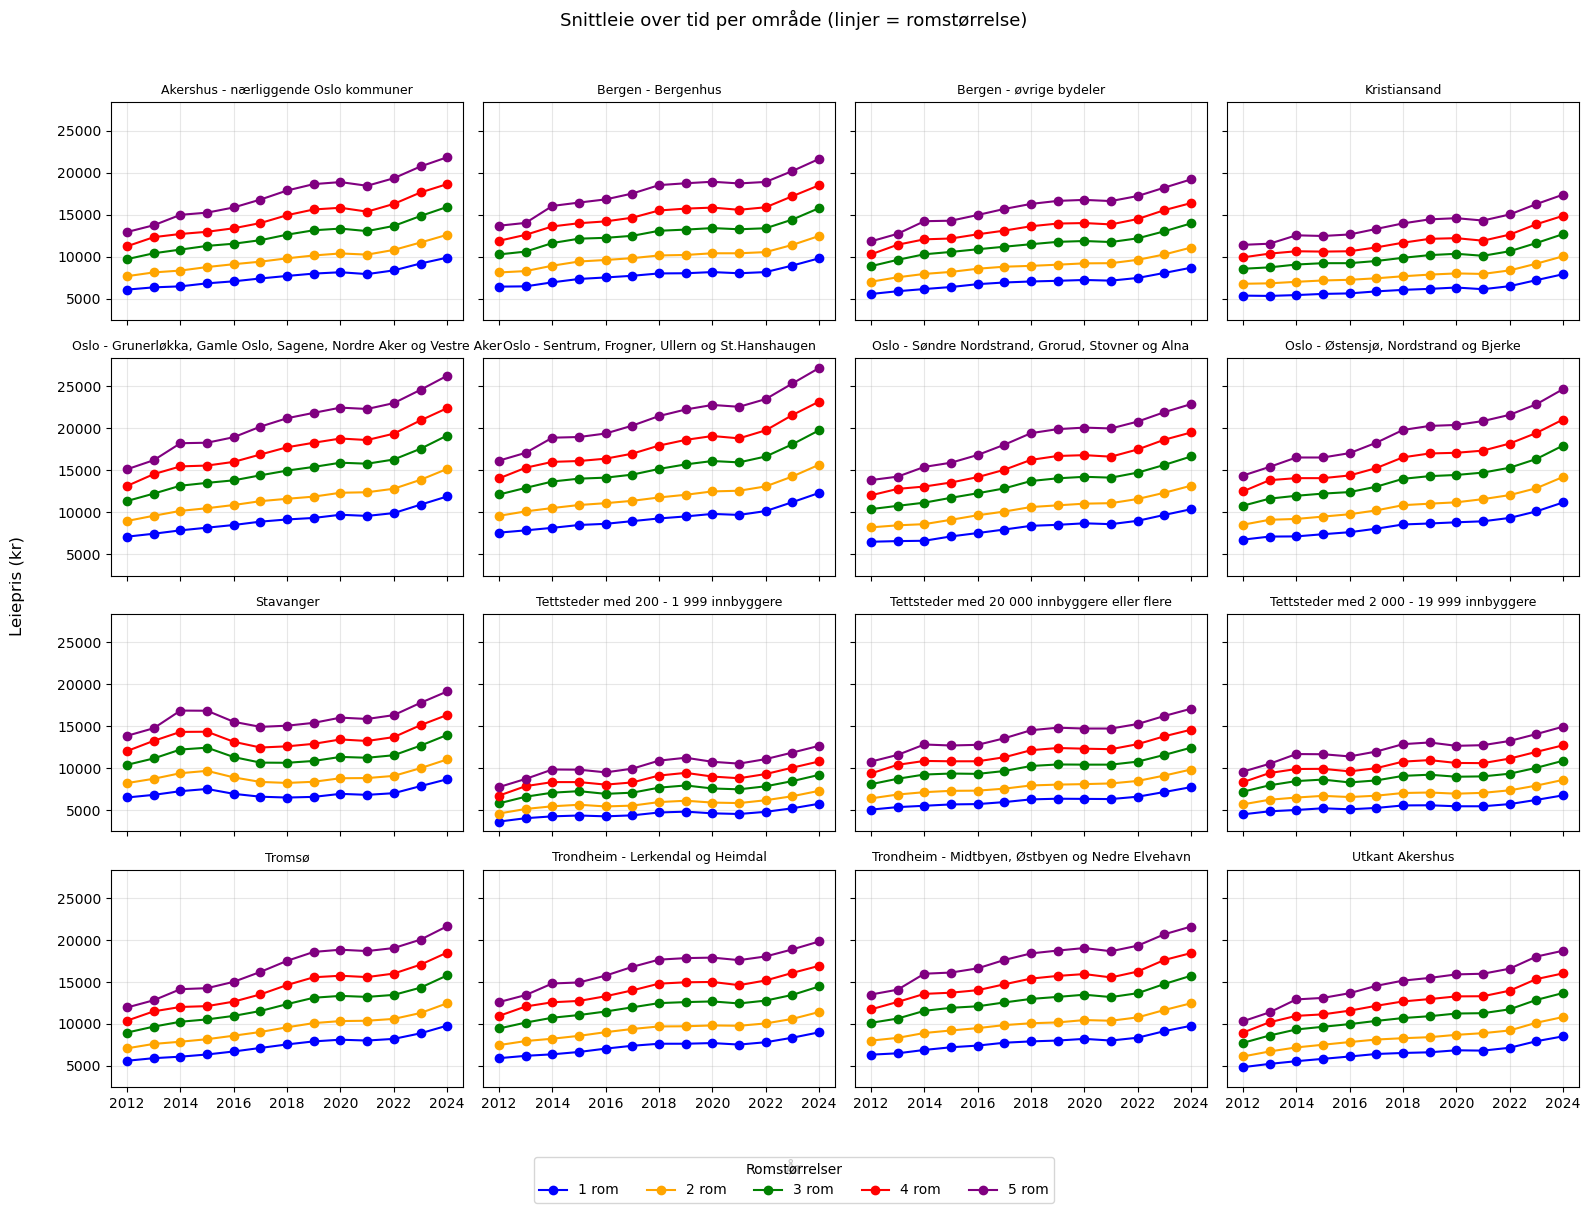

In [35]:
import math

#Prepare data for plotting
df_plot = (
    long_df
    .groupby(["Område", "år", "rom"], as_index=False)["leiepris"]
    .mean()
)

områder = sorted(df_plot["Område"].unique())
n = len(områder)


COLS = 4
ROWS = math.ceil(n / COLS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

farger = {1:"blue", 2:"orange", 3:"green", 4:"red", 5:"purple"} 


for i, område in enumerate(områder):
    r, c = divmod(i, COLS)
    ax = axes[r, c]
    sub = df_plot[df_plot["Område"] == område]

    for rom in sorted(sub["rom"].unique()):
        ss = sub[sub["rom"] == rom].sort_values("år")
        ax.plot(ss["år"], ss["leiepris"], marker="o",
                label=f"{rom} rom", color=farger.get(rom, "gray"))

    ax.set_title(område, fontsize=9)
    ax.grid(True, alpha=0.3)


for j in range(n, ROWS*COLS):
    r, c = divmod(j, COLS)
    axes[r, c].axis("off")


rom_labels = [f"{r} rom" for r in sorted(df_plot["rom"].unique())]
rom_colors = [farger.get(r, "gray") for r in sorted(df_plot["rom"].unique())]
handles = [plt.Line2D([0], [0], color=rom_colors[i], marker='o') for i in range(len(rom_labels))]
fig.legend(handles, rom_labels, title="Romstørrelser", loc="lower center",
           ncol=len(rom_labels), bbox_to_anchor=(0.5, -0.02))


fig.suptitle("Snittleie over tid per område (linjer = romstørrelse)", fontsize=13)
fig.text(0.5, 0.01, "År", ha="center", fontsize=12)
fig.text(0.01, 0.5, "Leiepris (kr)", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.03, 0.05, 1, 0.96])
plt.show()



In [36]:
import joblib

# Valide rom per område
rom_per_område = (long_df.dropna(subset=["rom"])
                  .groupby("Område")["rom"]
                  .unique().apply(lambda x: sorted(set(int(r) for r in x)))
                  .to_dict())

# Valid square meters per område og rom
m2_per_område_rom = (long_df.dropna(subset=["rom","størrelse_m2"])
                     .groupby(["Område","rom"])["størrelse_m2"]
                     .unique().apply(lambda x: sorted(set(int(v) for v in x)))
                     .to_dict())

joblib.dump(rom_per_område, "rom_per_område.pkl")
joblib.dump(m2_per_område_rom, "m2_per_område_rom.pkl")



['m2_per_område_rom.pkl']

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

model_p50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

model_p50.fit(X_train, y_train)

,loss,'quantile'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [38]:
from sklearn.metrics import mean_absolute_error

pred_val = model_p50.predict(X_val)
mae = mean_absolute_error(y_val, pred_val)
print(f"GRBR Validation MAE (2024): {mae:,.0f} kr")



GRBR Validation MAE (2024): 1,816 kr


In [39]:
from sklearn.metrics import  mean_squared_error, r2_score,mean_absolute_error,median_absolute_error
model_p50.fit(X_train, y_train)

mae = mean_absolute_error(y_val, pred_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2 = r2_score(y_val, pred_val)

print(f"GBRegressor Evaluation (2024):")
print(f"MAE  = {mae:,.0f} kr")
print(f"RMSE = {rmse:,.0f} kr")
print(f"R²   = {r2:.3f}")


GBRegressor Evaluation (2024):
MAE  = 1,816 kr
RMSE = 2,389 kr
R²   = 0.769


In [40]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist"
)

xgb.fit(X_train, y_train)

pred_val = xgb.predict(X_val)
mae = mean_absolute_error(y_val, pred_val)
r2  = r2_score(y_val, pred_val)
print(f"XGBoost - 2024: MAE {mae:,.0f} kr | R² {r2:.3f}")

#HMM to good model, suspicious?

XGBoost - 2024: MAE 1,016 kr | R² 0.954


In [41]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)  
param_grid = {'n_estimators': [200, 400, 600], 'max_depth': [3,4, 5,6,7,8,9,10], 'learning_rate': [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_copy, y)  # Use full data for CV
xgb_p50 = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600}


In [42]:
param_grid = {
    'n_estimators': [600],            # from previous tuning
    'max_depth': [3],                 # from previous tuning
    'learning_rate': [0.1],           # from previous tuning
    'subsample': [0.7, 0.8, 1.0],     # NEW
    'colsample_bytree': [0.7, 0.9, 1.0],  # NEW
    'reg_lambda': [0, 1.0, 10, 50],   # NEW
    'reg_alpha': [0, 0.1, 1]          # NEW
}
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best MAE for 2023:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.7}
Best MAE for 2023: 664.7766684570313


In [43]:
xgb = XGBRegressor(
    n_estimators=200,          # large cap; ES will stop earlier
    learning_rate=0.1,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,              # stronger L2
    reg_alpha=2,                # stronger L1
    min_child_weight=5,         # require more data per leaf
    gamma=1,                    # require gain to split
    random_state=42,
    tree_method="hist"
)

xgb.fit(
    X_train, y_train)

pred_val = xgb.predict(X_val)
print(
    "MAE", f"{mean_absolute_error(y_val, pred_val):,.0f}",
    "| RMSE", f"{np.sqrt(mean_squared_error(y_val, pred_val)):,.0f}",
    "| R²", f"{r2_score(y_val, pred_val):.3f}"
)


MAE 1,042 | RMSE 1,238 | R² 0.938


In [44]:
pred_train = xgb.predict(X_train)
mae_train = mean_absolute_error(y_train, pred_train)
mae_val = mean_absolute_error(y_val, pred_val)

print(f"Training MAE: {mae_train:,.0f} kr")
print(f"Validation MAE: {mae_val:,.0f} kr")
#Evaluate using a different model, XGBoost is severily overfitting.


Training MAE: 236 kr
Validation MAE: 1,042 kr


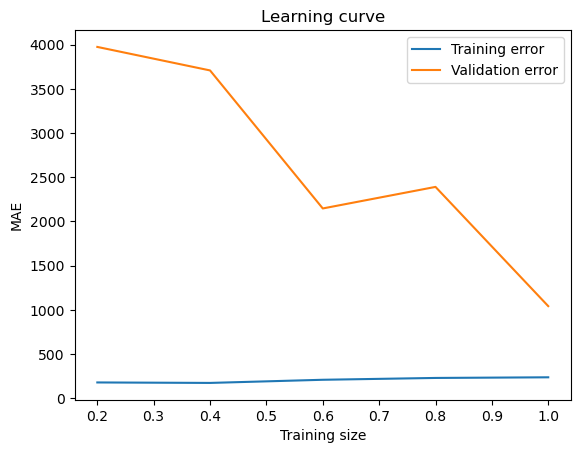

In [45]:
train_sizes = np.linspace(0.2, 1.0, 5)

train_errors, val_errors = [], []

for size in train_sizes:
    size = int(len(X_train)*size)
    xgb.fit(X_train[:size], y_train[:size])
    train_errors.append(mean_absolute_error(y_train[:size], xgb.predict(X_train[:size])))
    val_errors.append(mean_absolute_error(y_val, xgb.predict(X_val)))

plt.plot(train_sizes, train_errors, label="Training error")
plt.plot(train_sizes, val_errors, label="Validation error")
plt.xlabel("Training size")
plt.ylabel("MAE")
plt.legend()
plt.title("Learning curve")
plt.show()


In [46]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)  # alpha controls regularization. 

# Train on 2012–2023
ridge.fit(X_train, y_train)

# Predict on 2024 validation data
pred_val_ridge = ridge.predict(X_val)

# Evaluation
mae_ridge = mean_absolute_error(y_val, pred_val_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_val, pred_val_ridge))
r2_ridge = r2_score(y_val, pred_val_ridge)

print("Ridge Regression Performance (Validation 2024)")
print(f"MAE  = {mae_ridge:,.0f} kr")
print(f"RMSE = {rmse_ridge:,.0f} kr")
print(f"R²   = {r2_ridge:.3f}")



Ridge Regression Performance (Validation 2024)
MAE  = 1,263 kr
RMSE = 1,737 kr
R²   = 0.878


In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_cols = ["år", "rom", "størrelse_m2"]
cat_cols = [c for c in X_train.columns if c.startswith("Område_")]


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols)
    ],
    remainder="passthrough",  
    verbose_feature_names_out=False
)

ridge = Ridge(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", ridge),
])


param_grid = {
    "model__alpha": np.logspace(-2, 3, 20) 
    
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_ridge = grid.best_estimator_
print("Best alpha:", grid.best_params_["model__alpha"])
print("CV MAE (train years):", -grid.best_score_)

# Evaluate on 2024
pred_val_ridge = best_ridge.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_ridge)
rmse = np.sqrt(mean_squared_error(y_val, pred_val_ridge))
r2   = r2_score(y_val, pred_val_ridge)

print(f"MAE  = {mae:,.0f} kr")
print(f"RMSE = {rmse:,.0f} kr")
print(f"R²   = {r2:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha: 0.01
CV MAE (train years): 882.7245719202386
MAE  = 1,250 kr
RMSE = 1,708 kr
R²   = 0.882


In [48]:
# Build evaluation DataFrame for 2024
val_results = X_val.copy()
val_results["Område"] = long_df.loc[val_filter, "Område"].values  # restore Område column
val_results["y_true"] = y_val.values
val_results["y_pred"] = pred_val_ridge
val_results["error"] = val_results["y_pred"] - val_results["y_true"]
val_results["abs_error"] = val_results["error"].abs()




In [49]:
mae_per_area = (
    val_results.groupby("Område")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

print("MAE per area (sorted):")
mae_per_area


MAE per area (sorted):


Område
Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen                      2811.555619
Oslo - Grunerløkka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker    2546.229796
Oslo - Østensjø, Nordstrand og Bjerke                                 2350.988295
Tromsø                                                                1716.754997
Oslo - Søndre Nordstrand, Grorud, Stovner og Alna                     1612.239996
Akershus - nærliggende Oslo kommuner                                  1541.942339
Bergen - Bergenhus                                                    1227.997333
Trondheim - Midtbyen, Østbyen og Nedre Elvehavn                       1196.700243
Utkant Akershus                                                       1009.690965
Bergen - øvrige bydeler                                                721.083514
Trondheim - Lerkendal og Heimdal                                       698.407639
Tettsteder med 200 - 1 999 innbyggere                                  697.196192
Kristians

In [ ]:
""""
bias_per_area = (
    val_results.groupby("Område")["error"]
    .mean()
    .sort_values()
)

print("Bias per area (mean error):")
bias_per_area
""""

Bias per area (mean error):


Område
Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen                     -2529.434654
Oslo - Grunerløkka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker   -2255.955504
Oslo - Østensjø, Nordstrand og Bjerke                                -2183.652314
Tromsø                                                               -1616.065100
Akershus - nærliggende Oslo kommuner                                 -1372.944537
Oslo - Søndre Nordstrand, Grorud, Stovner og Alna                    -1345.970503
Utkant Akershus                                                       -961.750777
Bergen - Bergenhus                                                    -929.087999
Trondheim - Midtbyen, Østbyen og Nedre Elvehavn                       -883.055134
Kristiansand                                                          -603.363390
Bergen - øvrige bydeler                                               -525.708912
Trondheim - Lerkendal og Heimdal                                      -343.663780
Stavanger

In [ ]:
""""
bias_correction_factor = 0.75  

bias_adjustment = {
    area: bias * bias_correction_factor
    for area, bias in bias_per_area.items()
}

bias_adjustment
"""


{'Oslo - Sentrum, Frogner, Ullern og St.Hanshaugen': -1897.075990816615,
 'Oslo - Grunerløkka, Gamle Oslo, Sagene, Nordre Aker og Vestre Aker': -1691.9666277953825,
 'Oslo - Østensjø, Nordstrand og Bjerke': -1637.7392353751302,
 'Tromsø': -1212.0488250554722,
 'Akershus - nærliggende Oslo kommuner': -1029.7084030695391,
 'Oslo - Søndre Nordstrand, Grorud, Stovner og Alna': -1009.477877420394,
 'Utkant Akershus': -721.313082913543,
 'Bergen - Bergenhus': -696.81599948299,
 'Trondheim - Midtbyen, Østbyen og Nedre Elvehavn': -662.2913503046315,
 'Kristiansand': -452.5225425982221,
 'Bergen - øvrige bydeler': -394.28168396017423,
 'Trondheim - Lerkendal og Heimdal': -257.74783508846986,
 'Stavanger': -193.31268292687616,
 'Tettsteder med 20\xa0000 innbyggere eller flere': -187.37548083361415,
 'Tettsteder med 2\xa0000 - 19\xa0999 innbyggere': 133.5777207263318,
 'Tettsteder med 200 - 1\xa0999 innbyggere': 309.43775872506455}

In [ ]:
"""def predict_with_bias(area, X_row):
    base_pred = best_ridge.predict(X_row)[0]
    correction = bias_adjustment.get(area, 0)  # 0 if area not found
    return base_pred - correction  # subtract because bias was negative
    """

In [ ]:
"""corrected_preds = []
for i in range(len(X_val)):
    area = val_results["Område"].iloc[i]
    corrected_preds.append(predict_with_bias(area, X_val.iloc[[i]]))

mae_corrected = mean_absolute_error(y_val, corrected_preds)
print(f"New MAE after bias correction: {mae_corrected:,.0f} kr")"""


New MAE after bias correction: 866 kr


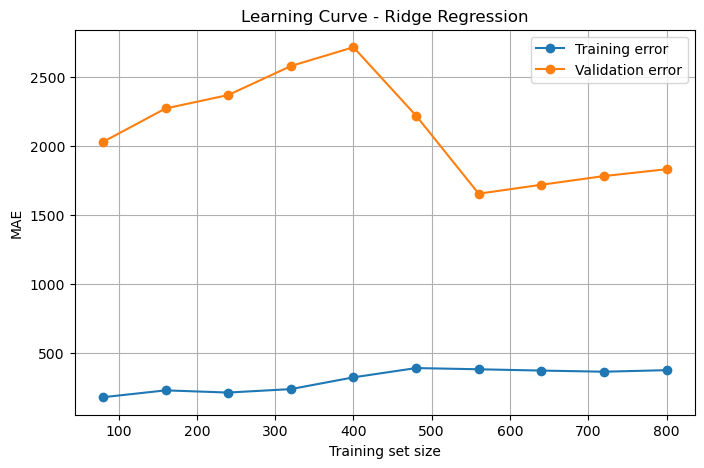

In [54]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_ridge,
    X=X_train,
    y=y_train,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_errors = -train_scores.mean(axis=1)
val_errors   = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_errors, label="Training error", marker='o')
plt.plot(train_sizes, val_errors, label="Validation error", marker='o')
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Learning Curve - Ridge Regression")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
joblib.dump(best_ridge, "ridge_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")
joblib.dump(list(long_df["Område"].unique()), "områder.pkl")
#joblib.dump(bias_adjustment, "bias_adjustment.pkl")


rom_per_område = (
    long_df.groupby("Område")["rom"]
    .unique()
    .apply(lambda x: sorted(set(int(r) for r in x)))
    .to_dict()
)
m2_per_område_rom = (
    long_df.groupby(["Område", "rom"])["størrelse_m2"]
    .unique()
    .apply(lambda x: sorted(set(int(v) for v in x)))
    .to_dict()
)
joblib.dump(rom_per_område, "rom_per_område.pkl")
joblib.dump(m2_per_område_rom, "m2_per_område_rom.pkl")



['m2_per_område_rom.pkl']

In [56]:
df_23_24 = long_df[long_df["år"].isin([2023, 2024])].copy()

area_year_avg = (
    df_23_24.groupby(["Område", "år"])["leiepris"]
    .mean()
    .unstack("år")
)

national_growth = (
    (df_23_24[df_23_24["år"]==2024]["leiepris"].mean() -
     df_23_24[df_23_24["år"]==2023]["leiepris"].mean()) /
     df_23_24[df_23_24["år"]==2023]["leiepris"].mean()
)

area_growth = ((area_year_avg[2024] - area_year_avg[2023]) / area_year_avg[2023]).replace([np.inf, -np.inf], np.nan)
area_growth = area_growth.fillna(national_growth)

joblib.dump(area_growth.to_dict(), "area_growth.pkl")
joblib.dump(float(national_growth), "national_growth.pkl")





['national_growth.pkl']

In [ ]:

ridge = joblib.load("ridge_model.pkl")
feature_columns = joblib.load("feature_columns.pkl")
#bias_adjustment = joblib.load("bias_adjustment.pkl")
area_growth = joblib.load("area_growth.pkl")
national_growth = joblib.load("national_growth.pkl")

def predict_2025_ridge(omraade: str, rom: int, storrelse_m2: float) -> dict:

    row = pd.DataFrame([{"år": 2025, "rom": int(rom), "størrelse_m2": float(storrelse_m2)}])
    for c in feature_columns:
        if c.startswith("Område_"):
            row[c] = 0
    col = f"Område_{omraade}"
    if col in feature_columns:
        row[col] = 1
    row = row.reindex(columns=feature_columns, fill_value=0)

    base = float(ridge.predict(row)[0])
    
    # bias = float(bias_adjustment.get(omraade, 0.0))     
    # corrected = base - bias
   
    corrected = base  

    g = float(area_growth.get(omraade, national_growth))
    pred_2025 = corrected * (1.0 + g)

    return {
        "base": base,
        # "bias_applied": -bias, 
        "growth": g,
        "pred_2025": pred_2025
    }


test_area = long_df["Område"].iloc[0]
print(predict_2025_ridge(test_area, rom=2, storrelse_m2=50))




{'base': 15038.032202473976, 'bias_applied': 1897.075990816615, 'growth': 0.08390373150805917, 'pred_2025': 18356.026964200377}
